# Datasets (Sentiment)

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [73]:
! wget -o data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
! pip install jsonlines

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

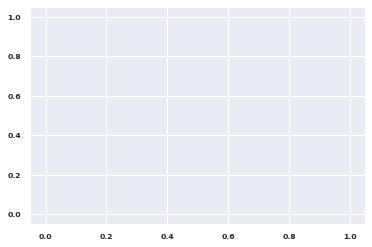

In [24]:
import json
import os
import random
import pickle
from collections import Counter
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")

#### Load reviews / categories (topics) + filter cats/make combinations

In [37]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats


def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [42]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [6]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [14]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

## Load reviews and topics (ALL)

In [8]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:40, 165791.98it/s]


In [9]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

192609it [00:01, 105847.95it/s]
100%|██████████| 192127/192127 [00:00<00:00, 1312819.89it/s]


In [10]:
inv_cat_combis = make_cat_combis(inv_bid_cats)

100%|██████████| 192127/192127 [00:00<00:00, 789491.05it/s]


---

### Filter all reviews - can only contain top50 Topics

In [11]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
f_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats)
f_inv_cat_bids = make_map_cats(f_inv_bid_cats)
f_inv_cat_combis = make_cat_combis(f_inv_bid_cats)
f_cat_pairs = make_cat_Ntuples(f_inv_cat_combis, n=2)

192609it [00:02, 91187.86it/s] 
100%|██████████| 5366/5366 [00:00<00:00, 361831.38it/s]


### Filter with minimum number of category combination occurrences

In [12]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
# f_cats = None

avg_num_of_cat_combis = int(sum(list(f_inv_cat_combis.values())) / len(f_inv_cat_combis))
fi_inv_cat_combis = filter_min_cat_combis(inv_cat_combis, min_num=30)

f2_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats, filter_cat_combis=fi_inv_cat_combis)

f2_inv_cat_bids = make_map_cats(f2_inv_bid_cats)
f2_inv_cat_combis = make_cat_combis(f2_inv_bid_cats)
f2_cat_pairs = make_cat_Ntuples(f2_inv_cat_combis, n=2)

192609it [00:02, 87382.19it/s]
100%|██████████| 102/102 [00:00<00:00, 424845.09it/s]


### Make NxN map and heatmap it

In [66]:
df_cm, cat_array, cat_labels = make_NxN_map(f_cats, f2_cat_pairs)

100%|██████████| 50/50 [00:00<00:00, 74658.31it/s]


#### Clustering

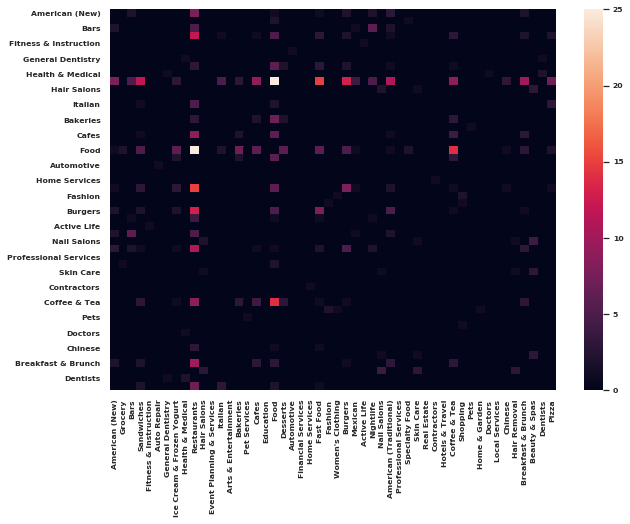

In [67]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}) # font size
plt.show()

<Figure size 1152x1152 with 0 Axes>

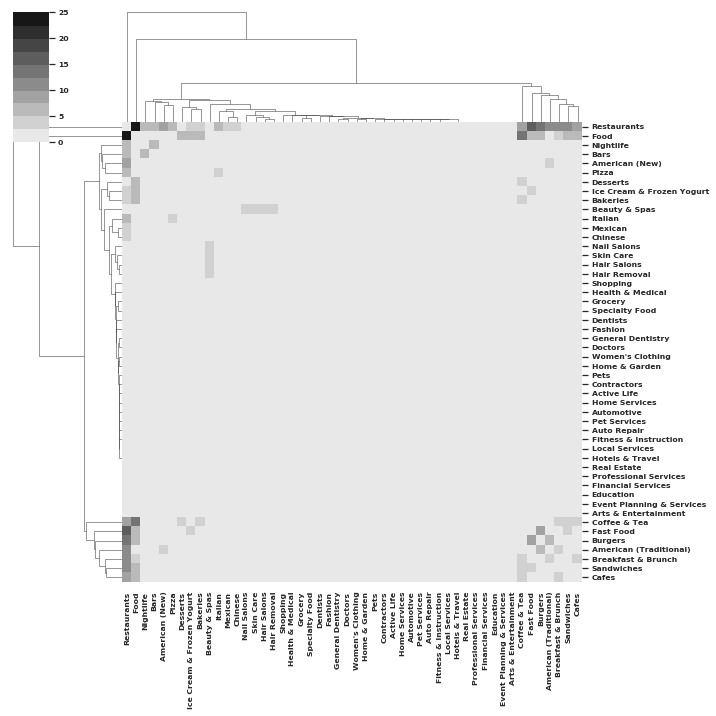

In [84]:
plt.figure(figsize = (16, 16))
sn.set(font_scale=0.7) # for label size
# pal = sn.dark_palette("palegreen", as_cmap=True, reverse=True)
pal = sn.color_palette("binary", 10)  # PuBu - BuGn - RdPu - Greys
sn.clustermap(df_cm, annot_kws={"size": 5}, cmap=pal)  # cmap="vlag") # plt.cm.Blues)

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


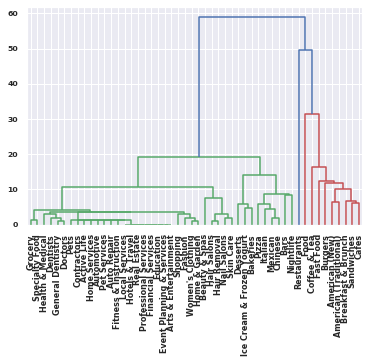

In [69]:
Z = hierarchy.linkage(df_cm, "ward")
#hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

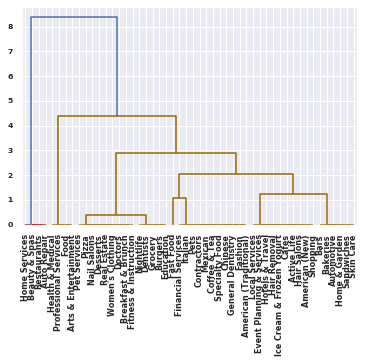

In [114]:
df_cm2 = ssd.squareform(df_cm)

Z = hierarchy.linkage(df_cm2, "ward")
hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

In [116]:
sc = SpectralClustering(5, affinity='precomputed', n_init=100, assign_labels='discretize')
cluster_labels = sc.fit_predict(cat_array)

# sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

Group 0:
American (Traditional); American (New); Mexican; Education; Hotels & Travel; Bars; Nightlife

Group 1:
Hair Salons; Skin Care; Hair Removal; Automotive; Nail Salons; Auto Repair; Pets; Beauty & Spas; Pet Services

Group 2:
Fashion; Shopping; Fitness & Instruction; Active Life; Women's Clothing; Home & Garden; Contractors; Home Services

Group 3:
General Dentistry; Breakfast & Brunch; Chinese; Doctors; Sandwiches; Real Estate; Burgers; Restaurants; Arts & Entertainment; Event Planning & Services; Pizza; Dentists; Italian; Professional Services; Local Services; Fast Food; Financial Services; Health & Medical

Group 4:
Specialty Food; Cafes; Coffee & Tea; Ice Cream & Frozen Yogurt; Desserts; Food; Grocery; Bakeries



/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [23]:
ac = AgglomerativeClustering(4, affinity='euclidean', linkage='ward')
csarr = cosine_similarity(cat_array)
cluster_labels = ac.fit_predict(csarr)

# sorted(list(zip(labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

Group 0:
Fitness & Instruction; Auto Repair; General Dentistry; Health & Medical; Event Planning & Services; Arts & Entertainment; Pet Services; Education; Automotive; Financial Services; Home Services; Fashion; Women's Clothing; Active Life; Professional Services; Real Estate; Contractors; Hotels & Travel; Shopping; Pets; Home & Garden; Doctors; Local Services; Dentists

Group 1:
American (New); Bars; Sandwiches; Italian; Cafes; Food; Fast Food; Burgers; Mexican; Nightlife; American (Traditional); Chinese; Breakfast & Brunch; Pizza

Group 2:
Grocery; Ice Cream & Frozen Yogurt; Restaurants; Bakeries; Desserts; Specialty Food; Coffee & Tea

Group 3:
Hair Salons; Nail Salons; Skin Care; Hair Removal; Beauty & Spas



In [25]:
# cat_array, \
# linear_kernel(cat_array), \
# cosine_similarity(cat_array), \
# cat_labels

### Stats for `cat_labels` in filtered category maps/lists etc.

In [26]:
# number of business ids given a specific category
sorted([(c, len(f_inv_cat_bids[c])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

[('Restaurants', 59371),
 ('Shopping', 31878),
 ('Food', 29989),
 ('Home Services', 19729),
 ('Beauty & Spas', 19370),
 ('Health & Medical', 17171),
 ('Local Services', 13932),
 ('Automotive', 13203),
 ('Nightlife', 13095),
 ('Bars', 11341)]

In [28]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

[('Restaurants', 3093),
 ('Food', 2548),
 ('Shopping', 1382),
 ('Event Planning & Services', 1205),
 ('Nightlife', 1181),
 ('Bars', 906),
 ('Arts & Entertainment', 826),
 ('Breakfast & Brunch', 789),
 ('American (Traditional)', 767),
 ('Sandwiches', 751)]

In [27]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f2_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

[('Restaurants', 62),
 ('Food', 39),
 ('Fast Food', 15),
 ('Coffee & Tea', 14),
 ('Burgers', 13),
 ('Sandwiches', 12),
 ('American (Traditional)', 11),
 ('Breakfast & Brunch', 10),
 ('Cafes', 9),
 ('Beauty & Spas', 9)]

In [122]:
# better with filtering
# category pairs for a given category
sorted([(c, [cc for cc in f2_cat_pairs.keys() if c in cc]) for c in cat_labels], key=lambda x: len(x[1]), reverse=True)[:5]

[('Food',
  [('Bakeries', 'Food'),
   ('Food', 'Ice Cream & Frozen Yogurt'),
   ('Desserts', 'Food'),
   ('Fast Food', 'Food'),
   ('Food', 'Restaurants'),
   ('Cafes', 'Food'),
   ('Coffee & Tea', 'Food'),
   ('Food', 'Sandwiches'),
   ('Food', 'Grocery'),
   ('Breakfast & Brunch', 'Food'),
   ('Food', 'Specialty Food'),
   ('Burgers', 'Food'),
   ('Chinese', 'Food'),
   ('Food', 'Mexican'),
   ('Food', 'Pizza'),
   ('Food', 'Italian'),
   ('American (New)', 'Food'),
   ('American (Traditional)', 'Food')]),
 ('Restaurants',
  [('Italian', 'Restaurants'),
   ('Pizza', 'Restaurants'),
   ('Chinese', 'Restaurants'),
   ('Bars', 'Restaurants'),
   ('Nightlife', 'Restaurants'),
   ('Fast Food', 'Restaurants'),
   ('Food', 'Restaurants'),
   ('Ice Cream & Frozen Yogurt', 'Restaurants'),
   ('American (Traditional)', 'Restaurants'),
   ('Mexican', 'Restaurants'),
   ('Breakfast & Brunch', 'Restaurants'),
   ('Cafes', 'Restaurants'),
   ('Coffee & Tea', 'Restaurants'),
   ('Restaurants', 'San

In [40]:
# category pairs for a category:
c = "Food"

print("filtered by top50\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f_cat_pairs.keys() if c in cc]])
print()
print("filtered by avg amount (+top50)\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f2_cat_pairs.keys() if c in cc]])

filtered by top50
 ['Chinese', 'Restaurants', 'Specialty Food', 'Bakeries', 'Bars', 'Mexican', 'Nightlife', 'Fast Food', 'Breakfast & Brunch', 'Coffee & Tea', 'Ice Cream & Frozen Yogurt', 'Desserts', 'Automotive', 'Grocery', 'Beauty & Spas', 'Health & Medical', 'Home & Garden', 'Shopping', 'Cafes', 'Sandwiches', 'Event Planning & Services', 'American (New)', 'Burgers', 'Pizza', 'American (Traditional)', 'Italian', 'Arts & Entertainment', 'Hotels & Travel', 'Home Services', 'Real Estate', 'Active Life', 'Education', 'Fashion', 'Professional Services', 'Local Services', 'Pets', 'Fitness & Instruction', 'Skin Care', 'Dentists', 'General Dentistry', 'Contractors', 'Hair Removal', "Women's Clothing", 'Doctors', 'Pet Services', 'Financial Services', 'Hair Salons', 'Auto Repair', 'Nail Salons']

filtered by avg amount (+top50)
 ['Bakeries', 'Ice Cream & Frozen Yogurt', 'Desserts', 'Fast Food', 'Restaurants', 'Cafes', 'Coffee & Tea', 'Sandwiches', 'Grocery', 'Breakfast & Brunch', 'Specialty Fo

In [41]:
f2_inv_cat_combis[("Food",)]  # businesses with only this category ... (filtering should not affect this value)

1823

In [57]:
f2_inv_cat_combis


Counter({('Restaurants',): 11387,
         ('Local Services',): 4443,
         ('Beauty & Spas', 'Hair Salons'): 3903,
         ('Beauty & Spas', 'Nail Salons'): 2376,
         ('Italian', 'Pizza', 'Restaurants'): 1163,
         ('Bakeries', 'Food'): 706,
         ('Active Life', 'Fitness & Instruction'): 2703,
         ('Italian', 'Restaurants'): 1182,
         ('Arts & Entertainment',): 1393,
         ('Fashion', 'Shopping', "Women's Clothing"): 2413,
         ('Fashion', 'Shopping'): 3057,
         ('Auto Repair', 'Automotive'): 5536,
         ('Food', 'Ice Cream & Frozen Yogurt'): 978,
         ('Beauty & Spas',): 2441,
         ('Doctors', 'Health & Medical'): 4413,
         ('Chinese', 'Restaurants'): 3214,
         ('Desserts', 'Food', 'Ice Cream & Frozen Yogurt'): 377,
         ('Dentists', 'Health & Medical'): 670,
         ('Home & Garden', 'Shopping'): 2324,
         ('Bakeries', 'Desserts', 'Food'): 302,
         ('Health & Medical',): 3011,
         ('Shopping',): 6661,
  

In [43]:
inv_bid_cats = f2_inv_bid_cats
inv_cat_bids = f2_inv_cat_bids
inv_cat_combis = f2_inv_cat_combis
cat_pairs = f2_cat_pairs

In [63]:
sum([len(b) for a, b in f2_inv_cat_bids.items()])

217045

In [64]:
inv_bid_cats = load_topics(fn_yelp_topics)
sum([len(b) for a, b in inv_cat_bids.items()])

192609it [00:01, 100045.55it/s]


217045

In [ ]:
https://www.yelp.com/developers/documentation/v3/all_category_list

In [72]:
len(f2_inv_cat_combis)  # number of category combinations

102

---

#### Statistics

In [44]:
print(f"Number of businesses with categories: {len(inv_bid_cats):>6}")
print(f"                  without categories: {len(bids_not_cats):>6}")
print(f"Number of categories: len(inv_cat_bids) = {len(inv_cat_bids)}")

Number of businesses with categories: 109907
                  without categories:    482
Number of categories: len(inv_cat_bids) = 45


In [45]:
inv_cat_combis.most_common(20)

[(('Restaurants',), 11387),
 (('Shopping',), 6661),
 (('Auto Repair', 'Automotive'), 5536),
 (('Local Services',), 4443),
 (('Doctors', 'Health & Medical'), 4413),
 (('Beauty & Spas', 'Hair Salons'), 3903),
 (('Chinese', 'Restaurants'), 3214),
 (('Fashion', 'Shopping'), 3057),
 (('Health & Medical',), 3011),
 (('Active Life', 'Fitness & Instruction'), 2703),
 (('Dentists', 'General Dentistry', 'Health & Medical'), 2565),
 (('Pet Services', 'Pets'), 2468),
 (('Beauty & Spas',), 2441),
 (('Pizza', 'Restaurants'), 2436),
 (('Coffee & Tea', 'Food'), 2423),
 (('Fashion', 'Shopping', "Women's Clothing"), 2413),
 (('Beauty & Spas', 'Nail Salons'), 2376),
 (('Home & Garden', 'Shopping'), 2324),
 (('Mexican', 'Restaurants'), 2292),
 (('Bars', 'Nightlife'), 2015)]

In [46]:
# count single categories
cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
cnt.most_common(20)

[('Restaurants', 41278),
 ('Food', 14478),
 ('Shopping', 14455),
 ('Beauty & Spas', 11480),
 ('Health & Medical', 10659),
 ('Nightlife', 5990),
 ('Bars', 5636),
 ('Fast Food', 5590),
 ('Automotive', 5536),
 ('Auto Repair', 5536),
 ('Fashion', 5470),
 ('Coffee & Tea', 4997),
 ('Pizza', 4730),
 ('Hair Salons', 4641),
 ('Local Services', 4443),
 ('Doctors', 4413),
 ('Sandwiches', 3906),
 ('Nail Salons', 3845),
 ('Chinese', 3683),
 ('American (Traditional)', 3524)]

In [47]:
# Check for subgraphs naive

## build mapping for occurrence of each categories with other categories
map_cat_cats = dict()

for cats in tqdm(inv_bid_cats.values()):
    for cat in cats:
        try:
            map_cat_cats[cat].update(cats)
        except KeyError:
            map_cat_cats[cat] = set(cats)

cnt_cat_cats = Counter({cat: len(cats) for cat, cats in tqdm(map_cat_cats.items())})
            
set_all_cats = set(map_cat_cats.keys())

100%|██████████| 45/45 [00:00<00:00, 242913.36it/s]


In [48]:
print(f"Number of all cats: {len(set_all_cats)}")
cnt_cat_cats.most_common(20)

Number of all cats: 45


[('Food', 19),
 ('Restaurants', 18),
 ('Fast Food', 12),
 ('American (Traditional)', 12),
 ('Sandwiches', 11),
 ('Coffee & Tea', 11),
 ('Burgers', 10),
 ('Breakfast & Brunch', 9),
 ('American (New)', 9),
 ('Ice Cream & Frozen Yogurt', 8),
 ('Cafes', 8),
 ('Pizza', 6),
 ('Bakeries', 6),
 ('Nightlife', 6),
 ('Bars', 6),
 ('Mexican', 6),
 ('Beauty & Spas', 5),
 ('Nail Salons', 5),
 ('Italian', 5),
 ('Desserts', 5)]

##### search for smallest any-connected subgraph ?

merge all groups of related categories to find any two groups that are fully distinct over n edges

In [49]:
## Try to compute distinct sub groups of categories
inv_cat_group_id = dict()  # Dict[str, int]
lst_cat_subgroups = list()  # List[List[str]]  # TODO: better Dict[int, Set[str]]

def _has_related_cat_in_group_already(cat):
    for rcat in map_cat_cats[cat]:
        if rcat in inv_cat_group_id:
            return True
    return False

def _find_related_cat_groups(cat):
    rcat_groups = list()
    for rcat in map_cat_cats[cat]:
        gid = inv_cat_group_id.get(rcat, None)
        if gid is not None:
            rcat_groups.append((rcat, gid))
    return rcat_groups

def _trim_group_ids():
    # search for empty groups (None or empty set)
    lst_shifting = list()
    for n, ele in enumerate(lst_cat_subgroups):
        if not ele:
            lst_shifting.append(n)

    if not lst_shifting:
        return

    # move larger current groups over empty groups with lower id
    for cat, old_gid in inv_cat_group_id.items():
        new_gid = old_gid
        for n in lst_shifting:
            if n < new_gid:
                # empty group before current group id,
                # reduce current group id (--> skip empty group)
                new_gid -= 1
        # update on change (check should not really matter)
        if new_gid != old_gid:
            inv_cat_group_id[cat] = new_gid

    for n in reversed(lst_shifting):
        del lst_cat_subgroups[n]

def _merge_related_cat_groups(cat, target_gid=None):
    if target_gid is None:
        # find first best gid
        # (a) check category
        target_gid = inv_cat_group_id.get(cat, None)
        # (b) check related categories
        if target_gid is None:
            for rcat in map_cat_cats[cat]:
                target_gid = inv_cat_group_id.get(rcat, None)
                if target_gid is not None:
                    break

    if target_gid is None:
        print(f"No category to merge for {cat}!")
        return

    # search for different group ids in related categories of cat
    set_old_gid = set()
    for rcat in map_cat_cats[cat]:
        other_gid = inv_cat_group_id.get(rcat, None)
        if other_gid is not None and other_gid != target_gid:
            set_old_gid.add(other_gid)

    # add non group related categories to target group
    for rcat in map_cat_cats[cat]:
        if rcat not in inv_cat_group_id:
            inv_cat_group_id[rcat] = target_gid
            lst_cat_subgroups[target_gid].add(rcat)

    # rewrite other group ids to target group id
    if not set_old_gid:
        return

    # rewrite inverse cat-gid mapping, empty old groups
    for old_gid in set_old_gid:
        old_rcats = lst_cat_subgroups[old_gid]
        for old_rcat in old_rcats:
            inv_cat_group_id[old_rcat] = target_gid
        lst_cat_subgroups[old_gid] = None

    _trim_group_ids()

# -----
            
for cat, _ in cnt_cat_cats.most_common(None):
    if cat in inv_cat_group_id:
        # an existing group has this category already
        # merge groups from related categories together
        # additionally add new elements to target group (merged group)
        _merge_related_cat_groups(cat)
        _trim_group_ids()
    else:
        # new group possible
        print(f"new group?: {cat}")
        if not _has_related_cat_in_group_already(cat):
            # open new group
            gid = len(lst_cat_subgroups)
            rcats = map_cat_cats[cat]
            lst_cat_subgroups.append(set(rcats))
            for icat in rcats:
                inv_cat_group_id[icat] = gid
        else:
            # merge groups
            _merge_related_cat_groups(cat)
            _trim_group_ids()

new group?: Food
new group?: Beauty & Spas
new group?: Shopping
new group?: Health & Medical
new group?: Fitness & Instruction
new group?: Automotive
new group?: Home Services
new group?: Pet Services
new group?: Local Services
new group?: Arts & Entertainment
new group?: Professional Services


In [50]:
print(f"Number of distinct groups: {len(lst_cat_subgroups)}")
print(f"Number of elements in first group: {len(lst_cat_subgroups[0])}")
print(f"Number of all categories: {len(set_all_cats)}")

Number of distinct groups: 11
Number of elements in first group: 21
Number of all categories: 45


In [51]:
lst_cat_subgroups

[{'American (New)',
  'American (Traditional)',
  'Bakeries',
  'Bars',
  'Breakfast & Brunch',
  'Burgers',
  'Cafes',
  'Chinese',
  'Coffee & Tea',
  'Desserts',
  'Fast Food',
  'Food',
  'Grocery',
  'Ice Cream & Frozen Yogurt',
  'Italian',
  'Mexican',
  'Nightlife',
  'Pizza',
  'Restaurants',
  'Sandwiches',
  'Specialty Food'},
 {'Beauty & Spas', 'Hair Removal', 'Hair Salons', 'Nail Salons', 'Skin Care'},
 {'Fashion', 'Home & Garden', 'Shopping', "Women's Clothing"},
 {'Dentists', 'Doctors', 'General Dentistry', 'Health & Medical'},
 {'Active Life', 'Fitness & Instruction'},
 {'Auto Repair', 'Automotive'},
 {'Contractors', 'Home Services'},
 {'Pet Services', 'Pets'},
 {'Local Services'},
 {'Arts & Entertainment'},
 {'Professional Services'}]

##### search for main groups 

groups can share related categories but can no directly appear together:  
`{A, b} - {C, b}` -- ok, `C` and `A` are not together but share related elements  
`{A, b, C} - {C, b}` -- not ok, as `C` is with `A`

In [52]:
lst_cat_dist_candidates = [cat for cat, _ in cnt_cat_cats.most_common(None)]
# TODO: maybe random shuffle of candidates?
set_cats_distinct = set()

# lst_cat_dist_candidates.pop(0)

while lst_cat_dist_candidates:
    cat = lst_cat_dist_candidates.pop(0)
    set_cats_distinct.add(cat)

    # remove directly related categories, i.e. categories that appear together
    # TODO: maybe compute frequency of co-occurrence of categories and make a cut-off???
    for rcat in map_cat_cats[cat]:
        try:
            lst_cat_dist_candidates.remove(rcat)
        except ValueError:
            # element not in list anymore
            pass

In [53]:
print(
    f"Number of distinct categories (starting from the largest): {len(set_cats_distinct)}"
)
cnt_dist_cats = Counter({
    cat: cnt
    for cat, cnt in cnt_cat_cats.most_common(None) if cat in set_cats_distinct
})
cnt_dist_cats.most_common(20)

Number of distinct categories (starting from the largest): 12


[('Food', 19),
 ('Nightlife', 6),
 ('Beauty & Spas', 5),
 ('Shopping', 4),
 ('Health & Medical', 4),
 ('Fitness & Instruction', 2),
 ('Automotive', 2),
 ('Home Services', 2),
 ('Pet Services', 2),
 ('Local Services', 1),
 ('Arts & Entertainment', 1),
 ('Professional Services', 1)]

maybe start with any element / or with random sorting (shuffled) N times and select the minimum length result or with the best mean/avg value?

##### search for distinct groups but just with no element intersection

In [55]:
lst_cat_dist_candidates = [cat for cat, _ in cnt_cat_cats.most_common(None)]
# TODO: maybe random shuffle of candidates?
set_cats_distinct = set()

# [lst_cat_dist_candidates.pop(0) for _ in range(1)]

while lst_cat_dist_candidates:
    cat = lst_cat_dist_candidates.pop(0)
    set_cats_distinct.add(cat)

    # remove directly related categories, i.e. categories that appear together
    # TODO: maybe compute frequency of co-occurrence of categories and make a cut-off???
    for rcat in map_cat_cats[cat]:
        try:
            lst_cat_dist_candidates.remove(rcat)
        except ValueError:
            # element not in list anymore
            pass

    # remove categories that contain a shared related category
    for rcat in map_cat_cats[cat]:
        # for all current related categories
        # check any of the remaining categories
        for ocat in list(lst_cat_dist_candidates):
            # that they contain not any related category as our current one
            if rcat in set(map_cat_cats[ocat]):
                lst_cat_dist_candidates.remove(ocat)

In [56]:
print(
    f"Number of distinct categories (starting from the largest): {len(set_cats_distinct)}"
)
cnt_dist_cats = Counter({
    cat: cnt
    for cat, cnt in cnt_cat_cats.most_common(None) if cat in set_cats_distinct
})
cnt_dist_cats.most_common(20)

Number of distinct categories (starting from the largest): 11


[('Food', 19),
 ('Beauty & Spas', 5),
 ('Shopping', 4),
 ('Health & Medical', 4),
 ('Fitness & Instruction', 2),
 ('Automotive', 2),
 ('Home Services', 2),
 ('Pet Services', 2),
 ('Local Services', 1),
 ('Arts & Entertainment', 1),
 ('Professional Services', 1)]

#### Test / Playground

In [ ]:
# exceprt
df  # .count()

In [ ]:
# ratings info
df.describe()

In [ ]:
# how many reviews per business (id)
df.groupby("id").count()[["rating"]].describe()

In [ ]:
# def fn_goodness(row):
#     row["good"] = True if row["rating"].value >= 2.5 else False
#     return row

# try:
#     df = df.progress_apply(fn_goodness, axis=1)
# except AttributeError:
#     df = df.apply(fn_goodness)

# set good if more than 3 in rating
df["goodness"] = df["rating"] > 3

In [ ]:
df.groupby(["goodness", "id"]).count()

In [ ]:
# select only those that have more than N reviews
df.groupby(["id", "goodness"])[["id"]].count() > 3

In [ ]:
# select only those IDs that contain both pos + negative reviews
df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2

In [ ]:
len(df), len(df[df["rating"] == 3])

In [ ]:
inv_bid_cats[list(inv_bid_cats.keys())[0]]

In [ ]:
df.groupby(["rating"], ).count()[["id"]]

#### Filter reviews with at least N ratings

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df = filter_min_review_freq(df, min_ratings=5)

#### Filter only reviews with both good and bad rating

In [ ]:
df = filter_both_good_bad(df)

#### Make pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [ ]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [ ]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

In [ ]:
pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)

print("#ss (pos)", len(pairs_good))
print("#ss (neg)", len(pairs_bad))

##### not same-sentiment pairs (combinations positive + negative)

In [ ]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [ ]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

In [ ]:
pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)

print("#nss", len(pairs_not_ss))

##### dataframe for training etc.

In [ ]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if os.path.exists(fn_yelp_df):
        with open(fn_yelp_df, "rb") as fp:
            all_df = pickle.load(fp)
        return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    with open(fn_yelp_df, "wb") as fp:
        pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

In [ ]:
pairs_all = pairs_good + pairs_bad + pairs_not_ss
print("#~ss", len(pairs_all))

# print(pairs_all[0]["argument1_id"])
np.random.shuffle(pairs_all)
# print(pairs_all[0]["argument1_id"])

df_traindev = pd.DataFrame.from_dict(pairs_all)

In [ ]:
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "wb") as fp:
    pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

#### Reloading for training

In [ ]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [ ]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

In [ ]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

In [ ]:
# len(traindev_df), len(test_df)